<!-- HTML file automatically generated from DocOnce source (https://github.com/doconce/doconce/)
doconce format html week38.do.txt --no_mako -->
<!-- dom:TITLE: Week 38: Logistic Regression and Optimization -->

# Week 38: Logistic Regression and Optimization
**Morten Hjorth-Jensen**, Department of Physics and Center for Computing in Science Education, University of Oslo and Department of Physics and Astronomy and Facility for Rare Isotope Beams, Michigan State University

Date: **September 18-22**

## Plans for week 38

**Material for the active learning sessions on Tuesday and Wednesday.**

  * Lecture from last week on the bias-variance tradeoff

  * Resampling techniques, cross-validation examples included here, see also the lectures from last week on the bootstrap method

  * Exercise for week 38, see also the whiteboard notes from week 37 at <https://github.com/CompPhysics/MachineLearning/blob/master/doc/HandWrittenNotes/2023/NotesSep14.pdf>

  * Work on project 1, in particular resampling methods like cross-validation and bootstrap.

  
**Material for the lecture on Thursday September 21.**

  * Logistic regression as our first encounter of classification methods. From binary cases to several categories.

  * Start gradient and optimization methods

  * Readings and Videos:

    * Hastie et al 4.1, 4.2 and 4.3 on logistic regression

    * For a good discussion on gradient methods, see Goodfellow et al section 4.3-4.5 and chapter 8. We will come back to the latter chapter in our discussion of Neural networks as well.

    * See also the whiteboard notes from week 37 at <https://github.com/CompPhysics/MachineLearning/blob/master/doc/HandWrittenNotes/2023/NotesSep14.pdf> for a discussion and derivation of the bias-variance tradeoff. 

    * [Video on Logistic regression](https://www.youtube.com/watch?v=C5268D9t9Ak)

    * [Yet another video on logistic regression](https://www.youtube.com/watch?v=yIYKR4sgzI8)

    * [Video on gradient descent](https://www.youtube.com/watch?v=sDv4f4s2SB8)

## Material from last week and relevant for the first project

## Various steps in cross-validation

When the repetitive splitting of the data set is done randomly,
samples may accidently end up in a fast majority of the splits in
either training or test set. Such samples may have an unbalanced
influence on either model building or prediction evaluation. To avoid
this $k$-fold cross-validation structures the data splitting. The
samples are divided into $k$ more or less equally sized exhaustive and
mutually exclusive subsets. In turn (at each split) one of these
subsets plays the role of the test set while the union of the
remaining subsets constitutes the training set. Such a splitting
warrants a balanced representation of each sample in both training and
test set over the splits. Still the division into the $k$ subsets
involves a degree of randomness. This may be fully excluded when
choosing $k=n$. This particular case is referred to as leave-one-out
cross-validation (LOOCV).

## How to set up the cross-validation for Ridge and/or Lasso

* Define a range of interest for the penalty parameter.

* Divide the data set into training and test set comprising samples $\{1, \ldots, n\} \setminus i$ and $\{ i \}$, respectively.

* Fit the linear regression model by means of for example Ridge or Lasso regression  for each $\lambda$ in the grid using the training set, and the corresponding estimate of the error variance $\boldsymbol{\sigma}_{-i}^2(\lambda)$, as

$$
\begin{align*}
\boldsymbol{\beta}_{-i}(\lambda) & =  ( \boldsymbol{X}_{-i, \ast}^{T}
\boldsymbol{X}_{-i, \ast} + \lambda \boldsymbol{I}_{pp})^{-1}
\boldsymbol{X}_{-i, \ast}^{T} \boldsymbol{y}_{-i}
\end{align*}
$$

* Evaluate the prediction performance of these models on the test set by $C[y_i, \boldsymbol{X}_{i, \ast}; \boldsymbol{\beta}_{-i}(\lambda), \boldsymbol{\sigma}_{-i}^2(\lambda)]$. Or, by the prediction error $|y_i - \boldsymbol{X}_{i, \ast} \boldsymbol{\beta}_{-i}(\lambda)|$, the relative error, the error squared or the R2 score function.

* Repeat the first three steps  such that each sample plays the role of the test set once.

* Average the prediction performances of the test sets at each grid point of the penalty bias/parameter. It is an estimate of the prediction performance of the model corresponding to this value of the penalty parameter on novel data.

## Cross-validation in brief

For the various values of $k$

1. shuffle the dataset randomly.

2. Split the dataset into $k$ groups.

3. For each unique group:

a. Decide which group to use as set for test data

b. Take the remaining groups as a training data set

c. Fit a model on the training set and evaluate it on the test set

d. Retain the evaluation score and discard the model

5. Summarize the model using the sample of model evaluation scores

## Code Example for Cross-validation and $k$-fold Cross-validation

The code here uses Ridge regression with cross-validation (CV)  resampling and $k$-fold CV in order to fit a specific polynomial.

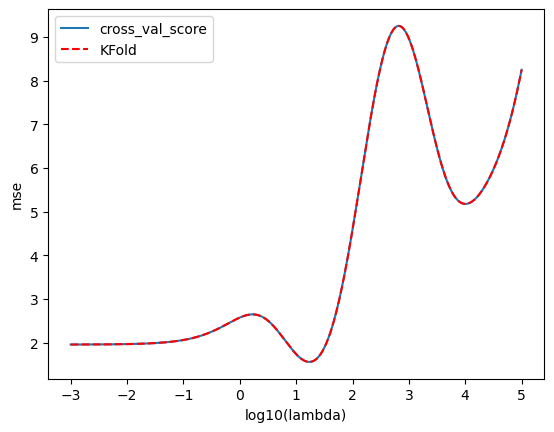

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures

# A seed just to ensure that the random numbers are the same for every run.
# Useful for eventual debugging.
np.random.seed(3155)

# Generate the data.
nsamples = 100
x = np.random.randn(nsamples)
y = 3*x**2 + np.random.randn(nsamples)

## Cross-validation on Ridge regression using KFold only

# Decide degree on polynomial to fit
poly = PolynomialFeatures(degree = 6)

# Decide which values of lambda to use
nlambdas = 500
lambdas = np.logspace(-3, 5, nlambdas)

# Initialize a KFold instance
k = 5
kfold = KFold(n_splits = k)

# Perform the cross-validation to estimate MSE
scores_KFold = np.zeros((nlambdas, k))

i = 0
for lmb in lambdas:
    ridge = Ridge(alpha = lmb)
    j = 0
    for train_inds, test_inds in kfold.split(x):
        xtrain = x[train_inds]
        ytrain = y[train_inds]

        xtest = x[test_inds]
        ytest = y[test_inds]

        Xtrain = poly.fit_transform(xtrain[:, np.newaxis])
        ridge.fit(Xtrain, ytrain[:, np.newaxis])

        Xtest = poly.fit_transform(xtest[:, np.newaxis])
        ypred = ridge.predict(Xtest)

        scores_KFold[i,j] = np.sum((ypred - ytest[:, np.newaxis])**2)/np.size(ypred)

        j += 1
    i += 1


estimated_mse_KFold = np.mean(scores_KFold, axis = 1)

## Cross-validation using cross_val_score from sklearn along with KFold

# kfold is an instance initialized above as:
# kfold = KFold(n_splits = k)

estimated_mse_sklearn = np.zeros(nlambdas)
i = 0
for lmb in lambdas:
    ridge = Ridge(alpha = lmb)

    X = poly.fit_transform(x[:, np.newaxis])
    estimated_mse_folds = cross_val_score(ridge, X, y[:, np.newaxis], scoring='neg_mean_squared_error', cv=kfold)

    # cross_val_score return an array containing the estimated negative mse for every fold.
    # we have to the the mean of every array in order to get an estimate of the mse of the model
    estimated_mse_sklearn[i] = np.mean(-estimated_mse_folds)

    i += 1

## Plot and compare the slightly different ways to perform cross-validation

plt.figure()

plt.plot(np.log10(lambdas), estimated_mse_sklearn, label = 'cross_val_score')
plt.plot(np.log10(lambdas), estimated_mse_KFold, 'r--', label = 'KFold')

plt.xlabel('log10(lambda)')
plt.ylabel('mse')

plt.legend()

plt.show()

## Material for lecture Thursday September 21

## Logistic Regression

In linear regression our main interest was centered on learning the
coefficients of a functional fit (say a polynomial) in order to be
able to predict the response of a continuous variable on some unseen
data. The fit to the continuous variable $y_i$ is based on some
independent variables $\boldsymbol{x}_i$. Linear regression resulted in
analytical expressions for standard ordinary Least Squares or Ridge
regression (in terms of matrices to invert) for several quantities,
ranging from the variance and thereby the confidence intervals of the
parameters $\boldsymbol{\beta}$ to the mean squared error. If we can invert
the product of the design matrices, linear regression gives then a
simple recipe for fitting our data.

## Classification problems

Classification problems, however, are concerned with outcomes taking
the form of discrete variables (i.e. categories). We may for example,
on the basis of DNA sequencing for a number of patients, like to find
out which mutations are important for a certain disease; or based on
scans of various patients' brains, figure out if there is a tumor or
not; or given a specific physical system, we'd like to identify its
state, say whether it is an ordered or disordered system (typical
situation in solid state physics); or classify the status of a
patient, whether she/he has a stroke or not and many other similar
situations.

The most common situation we encounter when we apply logistic
regression is that of two possible outcomes, normally denoted as a
binary outcome, true or false, positive or negative, success or
failure etc.

## Optimization and Deep learning

Logistic regression will also serve as our stepping stone towards
neural network algorithms and supervised deep learning. For logistic
learning, the minimization of the cost function leads to a non-linear
equation in the parameters $\boldsymbol{\beta}$. The optimization of the
problem calls therefore for minimization algorithms. This forms the
bottle neck of all machine learning algorithms, namely how to find
reliable minima of a multi-variable function. This leads us to the
family of gradient descent methods. The latter are the working horses
of basically all modern machine learning algorithms.

We note also that many of the topics discussed here on logistic 
regression are also commonly used in modern supervised Deep Learning
models, as we will see later.

## Basics

We consider the case where the dependent variables, also called the
responses or the outcomes, $y_i$ are discrete and only take values
from $k=0,\dots,K-1$ (i.e. $K$ classes).

The goal is to predict the
output classes from the design matrix $\boldsymbol{X}\in\mathbb{R}^{n\times p}$
made of $n$ samples, each of which carries $p$ features or predictors. The
primary goal is to identify the classes to which new unseen samples
belong.

Let us specialize to the case of two classes only, with outputs
$y_i=0$ and $y_i=1$. Our outcomes could represent the status of a
credit card user that could default or not on her/his credit card
debt. That is

$$
y_i = \begin{bmatrix} 0 & \mathrm{no}\\  1 & \mathrm{yes} \end{bmatrix}.
$$

## Linear classifier

Before moving to the logistic model, let us try to use our linear
regression model to classify these two outcomes. We could for example
fit a linear model to the default case if $y_i > 0.5$ and the no
default case $y_i \leq 0.5$.

We would then have our 
weighted linear combination, namely

<!-- Equation labels as ordinary links -->
<div id="_auto1"></div>

$$
\begin{equation}
\boldsymbol{y} = \boldsymbol{X}^T\boldsymbol{\beta} +  \boldsymbol{\epsilon},
\label{_auto1} \tag{1}
\end{equation}
$$

where $\boldsymbol{y}$ is a vector representing the possible outcomes, $\boldsymbol{X}$ is our
$n\times p$ design matrix and $\boldsymbol{\beta}$ represents our estimators/predictors.

## Some selected properties

The main problem with our function is that it takes values on the
entire real axis. In the case of logistic regression, however, the
labels $y_i$ are discrete variables. A typical example is the credit
card data discussed below here, where we can set the state of
defaulting the debt to $y_i=1$ and not to $y_i=0$ for one the persons
in the data set (see the full example below).

One simple way to get a discrete output is to have sign
functions that map the output of a linear regressor to values $\{0,1\}$,
$f(s_i)=sign(s_i)=1$ if $s_i\ge 0$ and 0 if otherwise. 
We will encounter this model in our first demonstration of neural networks.

Historically it is called the **perceptron** model in the machine learning
literature. This model is extremely simple. However, in many cases it is more
favorable to use a ``soft" classifier that outputs
the probability of a given category. This leads us to the logistic function.

## Simple example

The following example on data for coronary heart disease (CHD) as function of age may serve as an illustration. In the code here we read and plot whether a person has had CHD (output = 1) or not (output = 0). This ouput  is plotted the person's against age. Clearly, the figure shows that attempting to make a standard linear regression fit may not be very meaningful.

,ID,Age,Agegroup,CHD
0,1,21,1,0
1,2,23,1,0
2,3,25,1,1
3,4,29,1,0
4,5,21,1,0
...,...,...,...,...
95,96,61,8,1
96,97,69,8,1
97,98,65,8,1
98,99,64,8,1


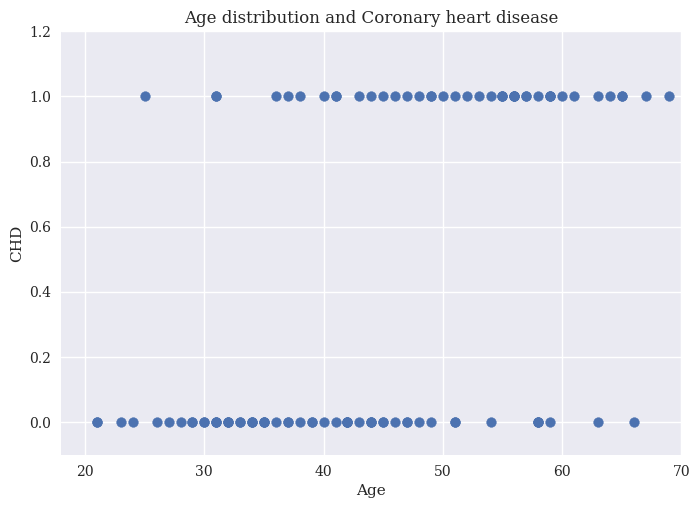

In [2]:
# Common imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error
from IPython.display import display
from pylab import plt, mpl
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'

# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "DataFiles/"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

infile = open(data_path("chddata.csv"),'r')

# Read the chd data as  csv file and organize the data into arrays with age group, age, and chd
chd = pd.read_csv(infile, names=('ID', 'Age', 'Agegroup', 'CHD'))
chd.columns = ['ID', 'Age', 'Agegroup', 'CHD']
output = chd['CHD']
age = chd['Age']
agegroup = chd['Agegroup']
numberID  = chd['ID'] 
display(chd)

plt.scatter(age, output, marker='o')
plt.axis([18,70.0,-0.1, 1.2])
plt.xlabel(r'Age')
plt.ylabel(r'CHD')
plt.title(r'Age distribution and Coronary heart disease')
plt.show()

## Plotting the mean value for each group

What we could attempt however is to plot the mean value for each group.

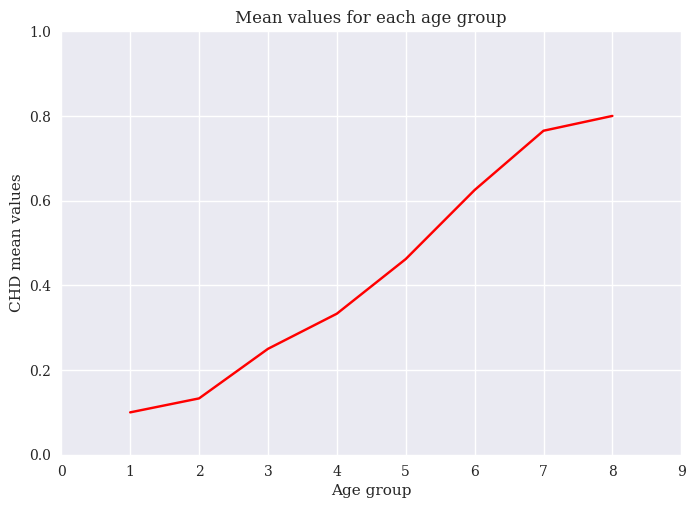

In [3]:
agegroupmean = np.array([0.1, 0.133, 0.250, 0.333, 0.462, 0.625, 0.765, 0.800])
group = np.array([1, 2, 3, 4, 5, 6, 7, 8])
plt.plot(group, agegroupmean, "r-")
plt.axis([0,9,0, 1.0])
plt.xlabel(r'Age group')
plt.ylabel(r'CHD mean values')
plt.title(r'Mean values for each age group')
plt.show()

We are now trying to find a function $f(y\vert x)$, that is a function which gives us an expected value for the output $y$ with a given input $x$.
In standard linear regression with a linear dependence on $x$, we would write this in terms of our model

$$
f(y_i\vert x_i)=\beta_0+\beta_1 x_i.
$$

This expression implies however that $f(y_i\vert x_i)$ could take any
value from minus infinity to plus infinity. If we however let
$f(y\vert y)$ be represented by the mean value, the above example
shows us that we can constrain the function to take values between
zero and one, that is we have $0 \le f(y_i\vert x_i) \le 1$. Looking
at our last curve we see also that it has an S-shaped form. This leads
us to a very popular model for the function $f$, namely the so-called
Sigmoid function or logistic model. We will consider this function as
representing the probability for finding a value of $y_i$ with a given
$x_i$.

## The logistic function

Another widely studied model, is the so-called 
perceptron model, which is an example of a "hard classification" model. We
will encounter this model when we discuss neural networks as
well. Each datapoint is deterministically assigned to a category (i.e
$y_i=0$ or $y_i=1$). In many cases, and the coronary heart disease data forms one of many such examples, it is favorable to have a "soft"
classifier that outputs the probability of a given category rather
than a single value. For example, given $x_i$, the classifier
outputs the probability of being in a category $k$.  Logistic regression
is the most common example of a so-called soft classifier. In logistic
regression, the probability that a data point $x_i$
belongs to a category $y_i=\{0,1\}$ is given by the so-called logit function (or Sigmoid) which is meant to represent the likelihood for a given event,

$$
p(t) = \frac{1}{1+\mathrm \exp{-t}}=\frac{\exp{t}}{1+\mathrm \exp{t}}.
$$

Note that $1-p(t)= p(-t)$.

## Examples of likelihood functions used in logistic regression and nueral networks

The following code plots the logistic function, the step function and other functions we will encounter from here and on.

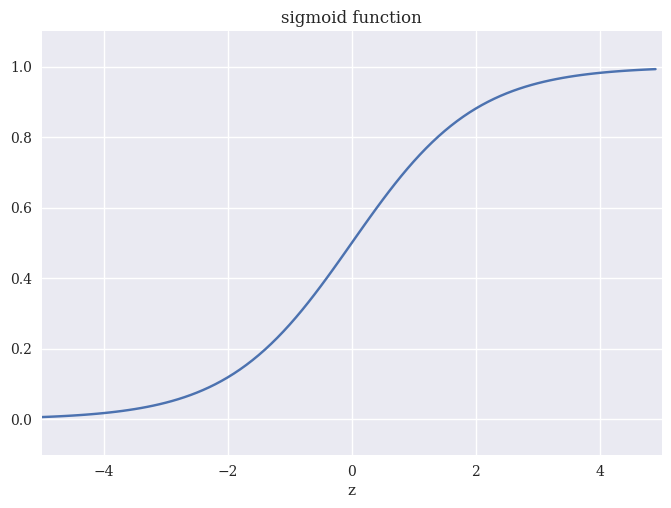

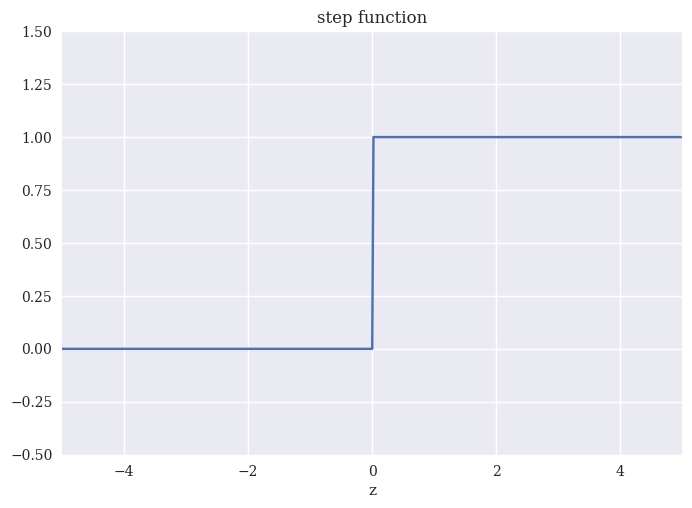

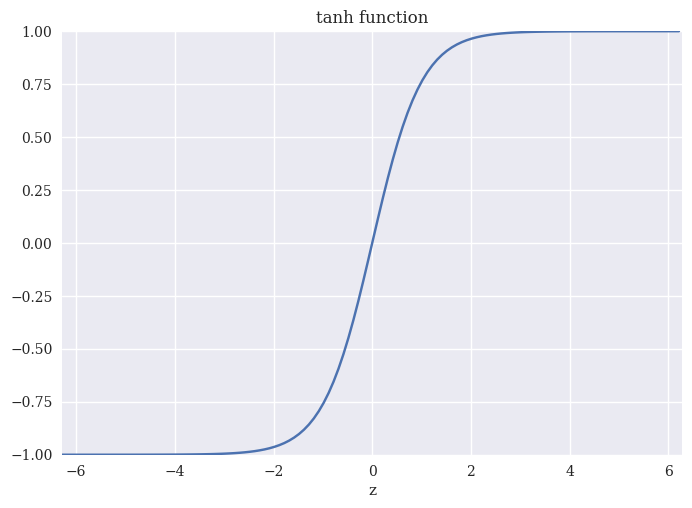

In [4]:
"""The sigmoid function (or the logistic curve) is a
function that takes any real number, z, and outputs a number (0,1).
It is useful in neural networks for assigning weights on a relative scale.
The value z is the weighted sum of parameters involved in the learning algorithm."""

import numpy
import matplotlib.pyplot as plt
import math as mt

z = numpy.arange(-5, 5, .1)
sigma_fn = numpy.vectorize(lambda z: 1/(1+numpy.exp(-z)))
sigma = sigma_fn(z)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(z, sigma)
ax.set_ylim([-0.1, 1.1])
ax.set_xlim([-5,5])
ax.grid(True)
ax.set_xlabel('z')
ax.set_title('sigmoid function')

plt.show()

"""Step Function"""
z = numpy.arange(-5, 5, .02)
step_fn = numpy.vectorize(lambda z: 1.0 if z >= 0.0 else 0.0)
step = step_fn(z)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(z, step)
ax.set_ylim([-0.5, 1.5])
ax.set_xlim([-5,5])
ax.grid(True)
ax.set_xlabel('z')
ax.set_title('step function')

plt.show()

"""tanh Function"""
z = numpy.arange(-2*mt.pi, 2*mt.pi, 0.1)
t = numpy.tanh(z)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(z, t)
ax.set_ylim([-1.0, 1.0])
ax.set_xlim([-2*mt.pi,2*mt.pi])
ax.grid(True)
ax.set_xlabel('z')
ax.set_title('tanh function')

plt.show()

## Two parameters

We assume now that we have two classes with $y_i$ either $0$ or $1$. Furthermore we assume also that we have only two parameters $\beta$ in our fitting of the Sigmoid function, that is we define probabilities

$$
\begin{align*}
p(y_i=1|x_i,\boldsymbol{\beta}) &= \frac{\exp{(\beta_0+\beta_1x_i)}}{1+\exp{(\beta_0+\beta_1x_i)}},\nonumber\\
p(y_i=0|x_i,\boldsymbol{\beta}) &= 1 - p(y_i=1|x_i,\boldsymbol{\beta}),
\end{align*}
$$

where $\boldsymbol{\beta}$ are the weights we wish to extract from data, in our case $\beta_0$ and $\beta_1$. 

Note that we used

$$
p(y_i=0\vert x_i, \boldsymbol{\beta}) = 1-p(y_i=1\vert x_i, \boldsymbol{\beta}).
$$

## Maximum likelihood

In order to define the total likelihood for all possible outcomes from a  
dataset $\mathcal{D}=\{(y_i,x_i)\}$, with the binary labels
$y_i\in\{0,1\}$ and where the data points are drawn independently, we use the so-called [Maximum Likelihood Estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) (MLE) principle. 
We aim thus at maximizing 
the probability of seeing the observed data. We can then approximate the 
likelihood in terms of the product of the individual probabilities of a specific outcome $y_i$, that is

$$
\begin{align*}
P(\mathcal{D}|\boldsymbol{\beta})& = \prod_{i=1}^n \left[p(y_i=1|x_i,\boldsymbol{\beta})\right]^{y_i}\left[1-p(y_i=1|x_i,\boldsymbol{\beta}))\right]^{1-y_i}\nonumber \\
\end{align*}
$$

from which we obtain the log-likelihood and our **cost/loss** function

$$
\mathcal{C}(\boldsymbol{\beta}) = \sum_{i=1}^n \left( y_i\log{p(y_i=1|x_i,\boldsymbol{\beta})} + (1-y_i)\log\left[1-p(y_i=1|x_i,\boldsymbol{\beta}))\right]\right).
$$

## The cost function rewritten

Reordering the logarithms, we can rewrite the **cost/loss** function as

$$
\mathcal{C}(\boldsymbol{\beta}) = \sum_{i=1}^n  \left(y_i(\beta_0+\beta_1x_i) -\log{(1+\exp{(\beta_0+\beta_1x_i)})}\right).
$$

The maximum likelihood estimator is defined as the set of parameters that maximize the log-likelihood where we maximize with respect to $\beta$.
Since the cost (error) function is just the negative log-likelihood, for logistic regression we have that

$$
\mathcal{C}(\boldsymbol{\beta})=-\sum_{i=1}^n  \left(y_i(\beta_0+\beta_1x_i) -\log{(1+\exp{(\beta_0+\beta_1x_i)})}\right).
$$

This equation is known in statistics as the **cross entropy**. Finally, we note that just as in linear regression, 
in practice we often supplement the cross-entropy with additional regularization terms, usually $L_1$ and $L_2$ regularization as we did for Ridge and Lasso regression.

## Minimizing the cross entropy

The cross entropy is a convex function of the weights $\boldsymbol{\beta}$ and,
therefore, any local minimizer is a global minimizer. 

Minimizing this
cost function with respect to the two parameters $\beta_0$ and $\beta_1$ we obtain

$$
\frac{\partial \mathcal{C}(\boldsymbol{\beta})}{\partial \beta_0} = -\sum_{i=1}^n  \left(y_i -\frac{\exp{(\beta_0+\beta_1x_i)}}{1+\exp{(\beta_0+\beta_1x_i)}}\right),
$$

and

$$
\frac{\partial \mathcal{C}(\boldsymbol{\beta})}{\partial \beta_1} = -\sum_{i=1}^n  \left(y_ix_i -x_i\frac{\exp{(\beta_0+\beta_1x_i)}}{1+\exp{(\beta_0+\beta_1x_i)}}\right).
$$

## A more compact expression

Let us now define a vector $\boldsymbol{y}$ with $n$ elements $y_i$, an
$n\times p$ matrix $\boldsymbol{X}$ which contains the $x_i$ values and a
vector $\boldsymbol{p}$ of fitted probabilities $p(y_i\vert x_i,\boldsymbol{\beta})$. We can rewrite in a more compact form the first
derivative of cost function as

$$
\frac{\partial \mathcal{C}(\boldsymbol{\beta})}{\partial \boldsymbol{\beta}} = -\boldsymbol{X}^T\left(\boldsymbol{y}-\boldsymbol{p}\right).
$$

If we in addition define a diagonal matrix $\boldsymbol{W}$ with elements 
$p(y_i\vert x_i,\boldsymbol{\beta})(1-p(y_i\vert x_i,\boldsymbol{\beta})$, we can obtain a compact expression of the second derivative as

$$
\frac{\partial^2 \mathcal{C}(\boldsymbol{\beta})}{\partial \boldsymbol{\beta}\partial \boldsymbol{\beta}^T} = \boldsymbol{X}^T\boldsymbol{W}\boldsymbol{X}.
$$

## Extending to more predictors

Within a binary classification problem, we can easily expand our model to include multiple predictors. Our ratio between likelihoods is then with $p$ predictors

$$
\log{ \frac{p(\boldsymbol{\beta}\boldsymbol{x})}{1-p(\boldsymbol{\beta}\boldsymbol{x})}} = \beta_0+\beta_1x_1+\beta_2x_2+\dots+\beta_px_p.
$$

Here we defined $\boldsymbol{x}=[1,x_1,x_2,\dots,x_p]$ and $\boldsymbol{\beta}=[\beta_0, \beta_1, \dots, \beta_p]$ leading to

$$
p(\boldsymbol{\beta}\boldsymbol{x})=\frac{ \exp{(\beta_0+\beta_1x_1+\beta_2x_2+\dots+\beta_px_p)}}{1+\exp{(\beta_0+\beta_1x_1+\beta_2x_2+\dots+\beta_px_p)}}.
$$

## Including more classes

Till now we have mainly focused on two classes, the so-called binary
system. Suppose we wish to extend to $K$ classes.  Let us for the sake
of simplicity assume we have only two predictors. We have then following model

$$
\log{\frac{p(C=1\vert x)}{p(K\vert x)}} = \beta_{10}+\beta_{11}x_1,
$$

and

$$
\log{\frac{p(C=2\vert x)}{p(K\vert x)}} = \beta_{20}+\beta_{21}x_1,
$$

and so on till the class $C=K-1$ class

$$
\log{\frac{p(C=K-1\vert x)}{p(K\vert x)}} = \beta_{(K-1)0}+\beta_{(K-1)1}x_1,
$$

and the model is specified in term of $K-1$ so-called log-odds or
**logit** transformations.

## More classes

In our discussion of neural networks we will encounter the above again
in terms of a slightly modified function, the so-called **Softmax** function.

The softmax function is used in various multiclass classification
methods, such as multinomial logistic regression (also known as
softmax regression), multiclass linear discriminant analysis, naive
Bayes classifiers, and artificial neural networks.  Specifically, in
multinomial logistic regression and linear discriminant analysis, the
input to the function is the result of $K$ distinct linear functions,
and the predicted probability for the $k$-th class given a sample
vector $\boldsymbol{x}$ and a weighting vector $\boldsymbol{\beta}$ is (with two
predictors):

$$
p(C=k\vert \mathbf {x} )=\frac{\exp{(\beta_{k0}+\beta_{k1}x_1)}}{1+\sum_{l=1}^{K-1}\exp{(\beta_{l0}+\beta_{l1}x_1)}}.
$$

It is easy to extend to more predictors. The final class is

$$
p(C=K\vert \mathbf {x} )=\frac{1}{1+\sum_{l=1}^{K-1}\exp{(\beta_{l0}+\beta_{l1}x_1)}},
$$

and they sum to one. Our earlier discussions were all specialized to
the case with two classes only. It is easy to see from the above that
what we derived earlier is compatible with these equations.

To find the optimal parameters we would typically use a gradient
descent method.  Newton's method and gradient descent methods are
discussed in the material on [optimization
methods](https://compphysics.github.io/MachineLearning/doc/pub/Splines/html/Splines-bs.html).

## Friday September 23

## Searching for Optimal Regularization Parameters $\lambda$

In project 1, when using Ridge and Lasso regression, we end up
searching for the optimal parameter $\lambda$ which minimizes our
selected scores (MSE or $R2$ values for example). The brute force
approach, as discussed in the code here for Ridge regression, consists
in evaluating the MSE as function of different $\lambda$ values.
Based on these calculations, one tries then to determine the value of the hyperparameter $\lambda$
which results in optimal scores (for example the smallest MSE or an $R2=1$).

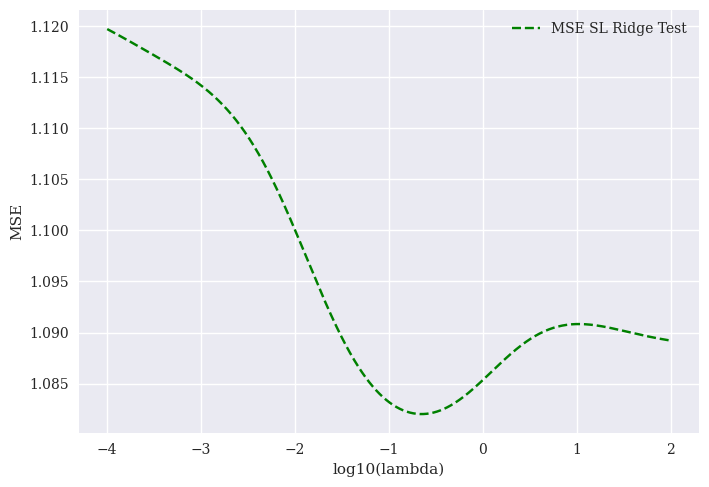

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model

def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n
# A seed just to ensure that the random numbers are the same for every run.
# Useful for eventual debugging.
np.random.seed(2021)

n = 100
x = np.random.rand(n)
y = np.exp(-x**2) + 1.5 * np.exp(-(x-2)**2)+ np.random.randn(n)

Maxpolydegree = 5
X = np.zeros((n,Maxpolydegree-1))

for degree in range(1,Maxpolydegree): #No intercept column
    X[:,degree-1] = x**(degree)

# We split the data in test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Decide which values of lambda to use
nlambdas = 500
MSERidgePredict = np.zeros(nlambdas)
lambdas = np.logspace(-4, 2, nlambdas)
for i in range(nlambdas):
    lmb = lambdas[i]
    RegRidge = linear_model.Ridge(lmb)
    RegRidge.fit(X_train,y_train)
    ypredictRidge = RegRidge.predict(X_test)
    MSERidgePredict[i] = MSE(y_test,ypredictRidge)

# Now plot the results
plt.figure()
plt.plot(np.log10(lambdas), MSERidgePredict, 'g--', label = 'MSE SL Ridge Test')
plt.xlabel('log10(lambda)')
plt.ylabel('MSE')
plt.legend()
plt.show()

Here we have performed a rather data greedy calculation as function of the regularization parameter $\lambda$. There is no resampling here. The latter can easily be added by employing the function **RidgeCV** instead of just calling the **Ridge** function. For **RidgeCV** we need to pass the array of $\lambda$ values.
By inspecting the figure we can in turn determine which is the optimal regularization parameter.
This becomes however less functional in the long run.

## Grid Search

An alternative is to use the so-called grid search functionality
included with the library **Scikit-Learn**, as demonstrated for the same
example here.

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)

def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

# A seed just to ensure that the random numbers are the same for every run.
# Useful for eventual debugging.
np.random.seed(2021)

n = 100
x = np.random.rand(n)
y = np.exp(-x**2) + 1.5 * np.exp(-(x-2)**2)+ np.random.randn(n)

Maxpolydegree = 5
X = np.zeros((n,Maxpolydegree-1))

for degree in range(1,Maxpolydegree): #No intercept column
    X[:,degree-1] = x**(degree)

# We split the data in test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Decide which values of lambda to use
nlambdas = 10
lambdas = np.logspace(-4, 2, nlambdas)
# create and fit a ridge regression model, testing each alpha
model = Ridge()
gridsearch = GridSearchCV(estimator=model, param_grid=dict(alpha=lambdas))
gridsearch.fit(X_train, y_train)
print(gridsearch)
ypredictRidge = gridsearch.predict(X_test)
# summarize the results of the grid search
print(f"Best estimated lambda-value: {gridsearch.best_estimator_.alpha}")
print(f"MSE score: {MSE(y_test,ypredictRidge)}")
print(f"R2 score: {R2(y_test,ypredictRidge)}")

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02])})
Best estimated lambda-value: 100.0
MSE score: 1.0892144853354966
R2 score: -0.0038332550504751595


By default the grid search function includes cross validation with
five folds. The [Scikit-Learn
documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)
contains more information on how to set the different parameters.

If we take out the random noise, running the above codes results in $\lambda=0$ yielding the best fit.

## Randomized Grid Search

An alternative to the above manual grid set up, is to use a random
search where the parameters are tuned from a random distribution
(uniform below) for a fixed number of iterations. A model is
constructed and evaluated for each combination of chosen parameters.
We repeat the previous example but now with a random search.  Note
that values of $\lambda$ are now limited to be within $x\in
[0,1]$. This domain may not be the most relevant one for the specific
case under study.

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform as randuniform
from sklearn.model_selection import RandomizedSearchCV


def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)

def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

# A seed just to ensure that the random numbers are the same for every run.
# Useful for eventual debugging.
np.random.seed(2021)

n = 100
x = np.random.rand(n)
y = np.exp(-x**2) + 1.5 * np.exp(-(x-2)**2)+ np.random.randn(n)

Maxpolydegree = 5
X = np.zeros((n,Maxpolydegree-1))

for degree in range(1,Maxpolydegree): #No intercept column
    X[:,degree-1] = x**(degree)

# We split the data in test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

param_grid = {'alpha': randuniform()}
# create and fit a ridge regression model, testing each alpha
model = Ridge()
gridsearch = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=100)
gridsearch.fit(X_train, y_train)
print(gridsearch)
ypredictRidge = gridsearch.predict(X_test)
# summarize the results of the grid search
print(f"Best estimated lambda-value: {gridsearch.best_estimator_.alpha}")
print(f"MSE score: {MSE(y_test,ypredictRidge)}")
print(f"R2 score: {R2(y_test,ypredictRidge)}")

RandomizedSearchCV(estimator=Ridge(), n_iter=100,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x156346610>})
Best estimated lambda-value: 0.9849967686928113
MSE score: 1.0853136633465326
R2 score: -0.0002382102844775691


## Wisconsin Cancer Data

We show here how we can use a simple regression case on the breast
cancer data using Logistic regression as our algorithm for
classification.

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import  train_test_split 
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

# Load the data
cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data,cancer.target,random_state=0)
print(X_train.shape)
print(X_test.shape)
# Logistic Regression
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)
print("Test set accuracy with Logistic Regression: {:.2f}".format(logreg.score(X_test,y_test)))

(426, 30)
(143, 30)
Test set accuracy with Logistic Regression: 0.94


/Users/mhjensen/miniforge3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Using the correlation matrix

In addition to the above scores, we could also study the covariance (and the correlation matrix).
We use **Pandas** to compute the correlation matrix.

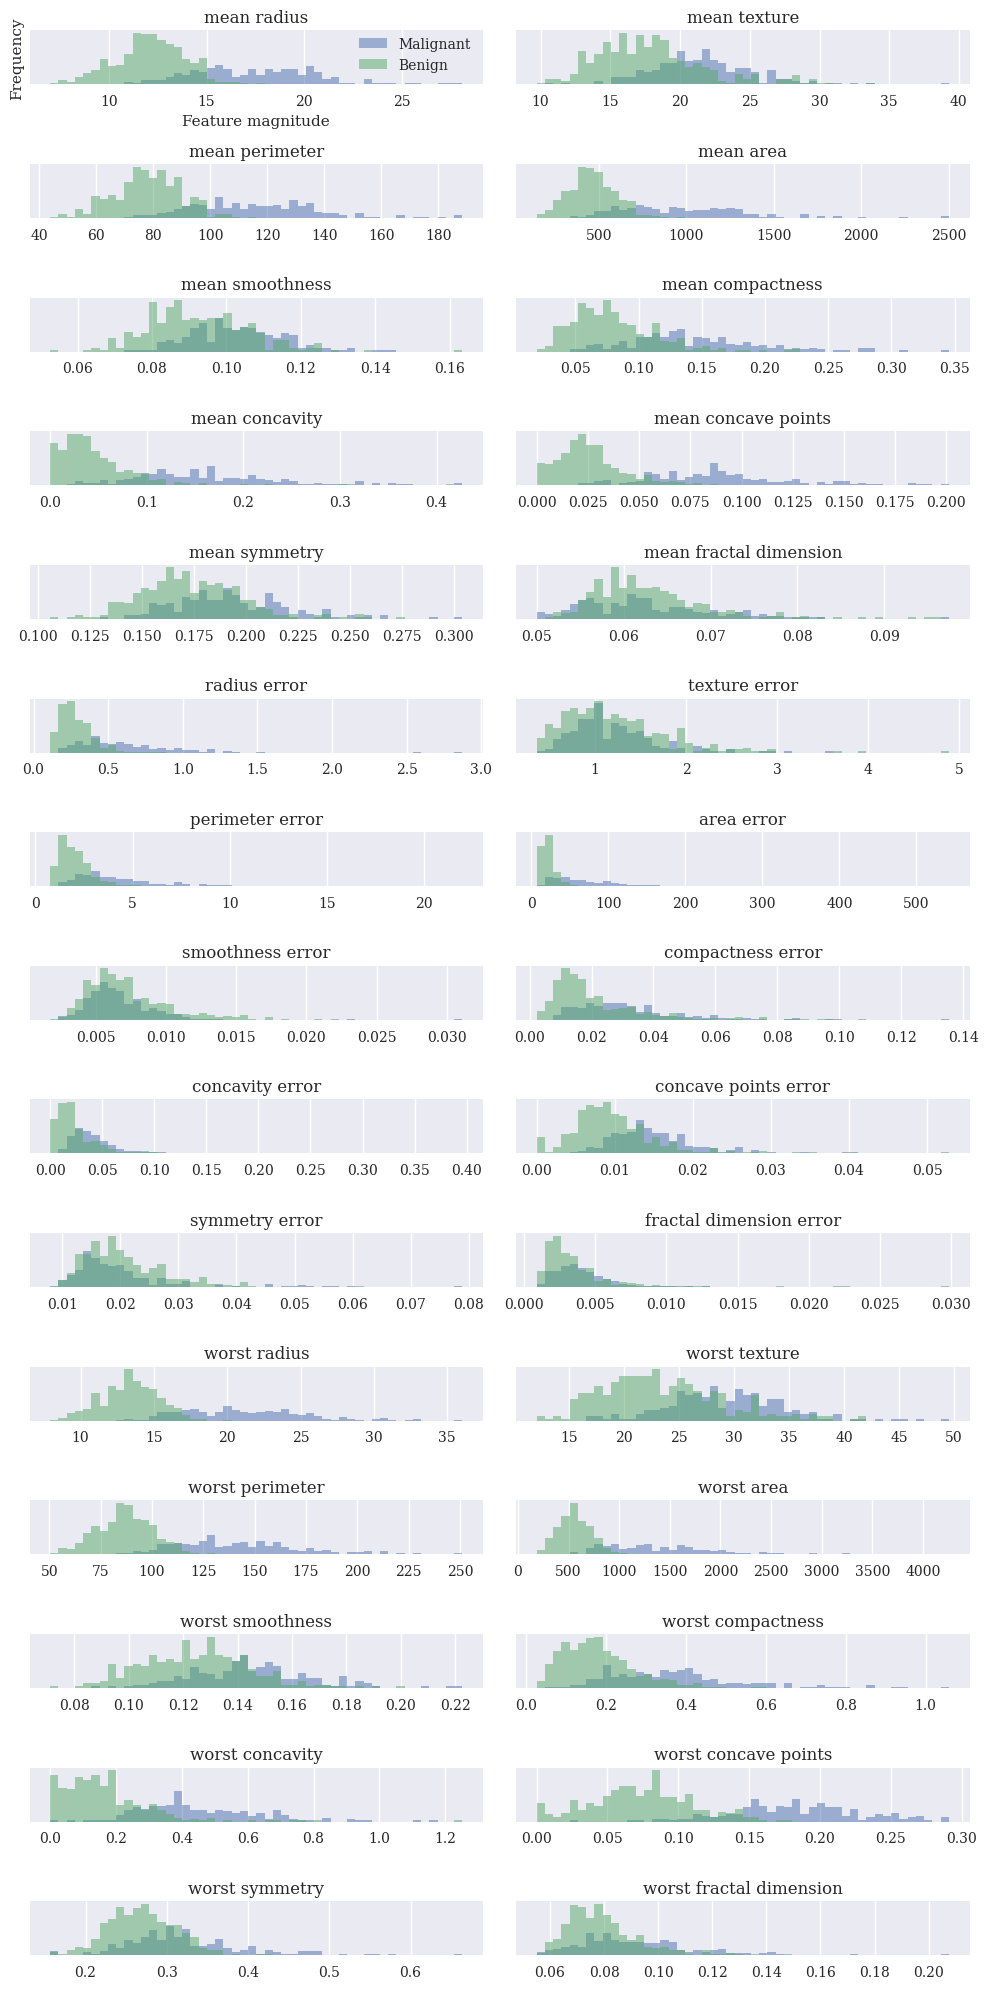

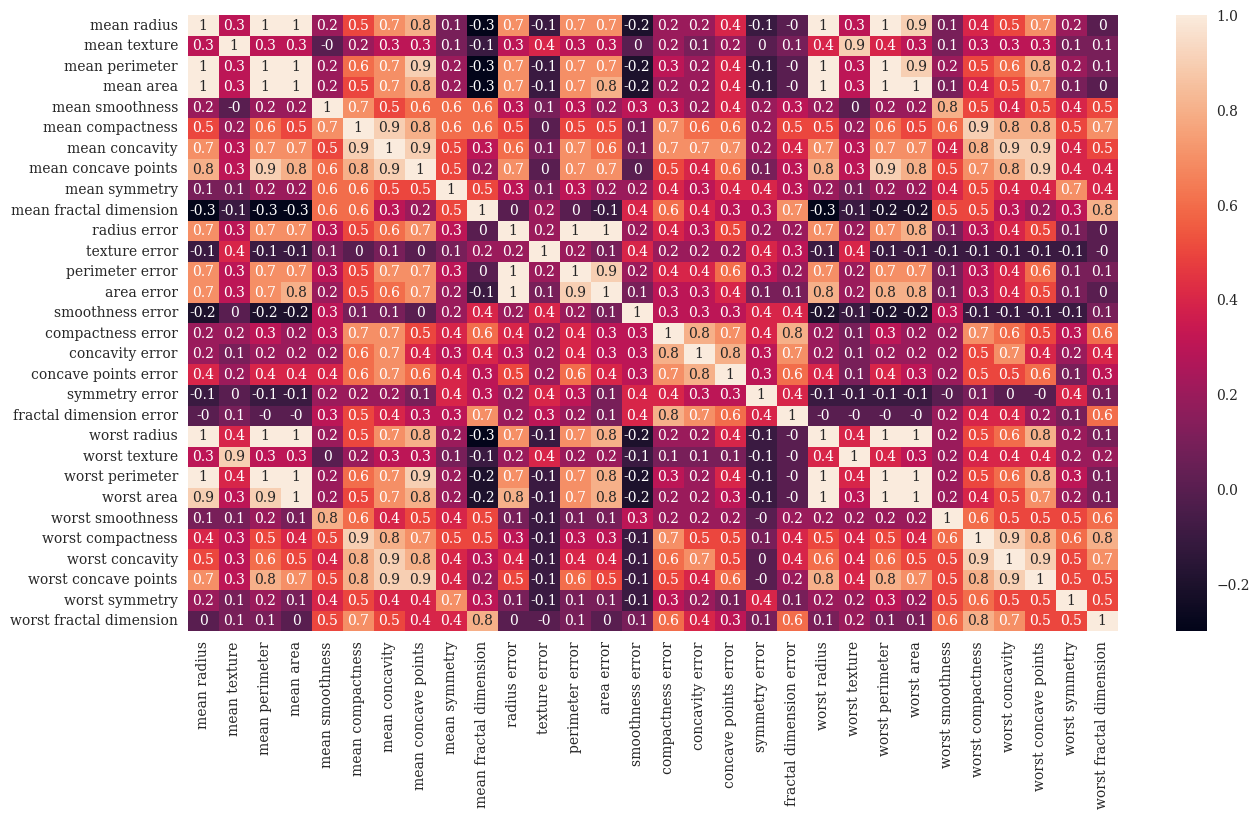

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import  train_test_split 
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
cancer = load_breast_cancer()
import pandas as pd
# Making a data frame
cancerpd = pd.DataFrame(cancer.data, columns=cancer.feature_names)

fig, axes = plt.subplots(15,2,figsize=(10,20))
malignant = cancer.data[cancer.target == 0]
benign = cancer.data[cancer.target == 1]
ax = axes.ravel()

for i in range(30):
    _, bins = np.histogram(cancer.data[:,i], bins =50)
    ax[i].hist(malignant[:,i], bins = bins, alpha = 0.5)
    ax[i].hist(benign[:,i], bins = bins, alpha = 0.5)
    ax[i].set_title(cancer.feature_names[i])
    ax[i].set_yticks(())
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
ax[0].legend(["Malignant", "Benign"], loc ="best")
fig.tight_layout()
plt.show()

import seaborn as sns
correlation_matrix = cancerpd.corr().round(1)
# use the heatmap function from seaborn to plot the correlation matrix
# annot = True to print the values inside the square
plt.figure(figsize=(15,8))
sns.heatmap(data=correlation_matrix, annot=True)
plt.show()

## Discussing the correlation data

In the above example we note two things. In the first plot we display
the overlap of benign and malignant tumors as functions of the various
features in the Wisconsing breast cancer data set. We see that for
some of the features we can distinguish clearly the benign and
malignant cases while for other features we cannot. This can point to
us which features may be of greater interest when we wish to classify
a benign or not benign tumour.

In the second figure we have computed the so-called correlation
matrix, which in our case with thirty features becomes a $30\times 30$
matrix.

We constructed this matrix using **pandas** via the statements

In [10]:
cancerpd = pd.DataFrame(cancer.data, columns=cancer.feature_names)

and then

In [11]:
correlation_matrix = cancerpd.corr().round(1)

Diagonalizing this matrix we can in turn say something about which
features are of relevance and which are not. This leads  us to
the classical Principal Component Analysis (PCA) theorem with
applications. This will be discussed later this semester ([week 43](https://compphysics.github.io/MachineLearning/doc/pub/week43/html/week43-bs.html)).

## Other measures in classification studies: Cancer Data  again

(426, 30)
(143, 30)
[1.         0.86666667 1.         0.92857143 1.         0.85714286
 1.         0.92857143 0.92857143 1.        ]
Test set accuracy with Logistic Regression: 0.94


/Users/mhjensen/miniforge3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mhjensen/miniforge3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

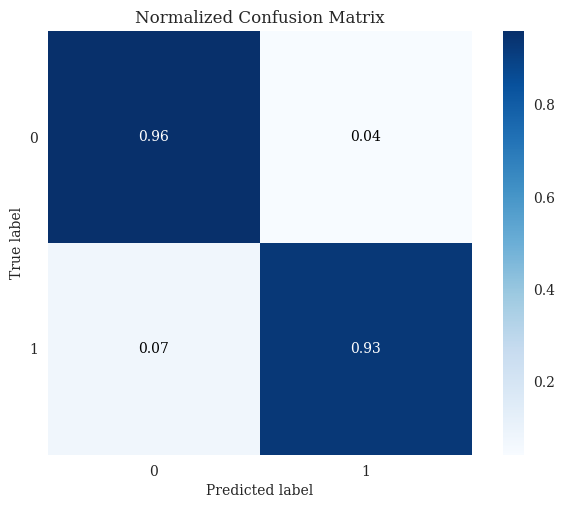

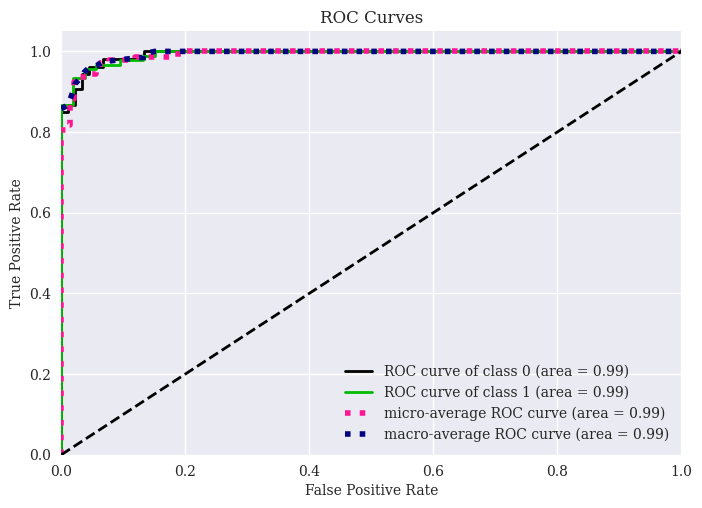

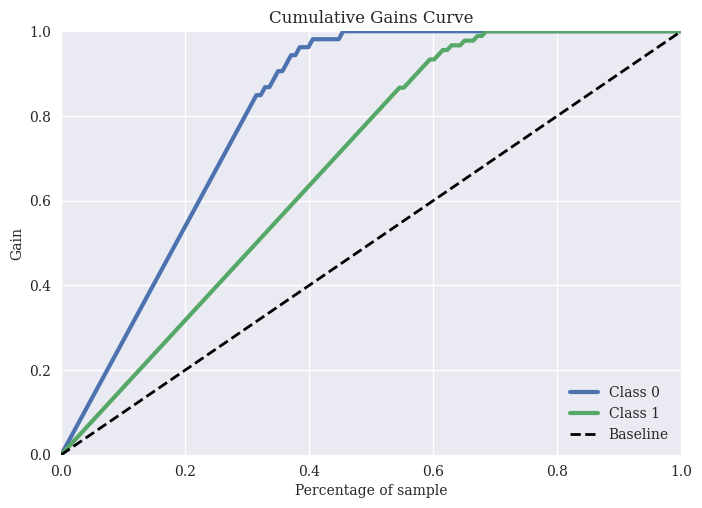

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import  train_test_split 
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

# Load the data
cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data,cancer.target,random_state=0)
print(X_train.shape)
print(X_test.shape)
# Logistic Regression
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
#Cross validation
accuracy = cross_validate(logreg,X_test,y_test,cv=10)['test_score']
print(accuracy)
print("Test set accuracy with Logistic Regression: {:.2f}".format(logreg.score(X_test,y_test)))

import scikitplot as skplt
y_pred = logreg.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()
y_probas = logreg.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_probas)
plt.show()
skplt.metrics.plot_cumulative_gain(y_test, y_probas)
plt.show()

## Optimization, the central part of any Machine Learning algortithm

[Overview Video, why do we care about gradient methods?](https://www.uio.no/studier/emner/matnat/fys/FYS-STK3155/h20/forelesningsvideoer/OverarchingAimsWeek39.mp4?vrtx=view-as-webpage)

Almost every problem in machine learning and data science starts with
a dataset $X$, a model $g(\beta)$, which is a function of the
parameters $\beta$ and a cost function $C(X, g(\beta))$ that allows
us to judge how well the model $g(\beta)$ explains the observations
$X$. The model is fit by finding the values of $\beta$ that minimize
the cost function. Ideally we would be able to solve for $\beta$
analytically, however this is not possible in general and we must use
some approximative/numerical method to compute the minimum.

## Revisiting our Logistic Regression case

In our discussion on Logistic Regression we studied the 
case of
two classes, with $y_i$ either
$0$ or $1$. Furthermore we assumed also that we have only two
parameters $\beta$ in our fitting, that is we
defined probabilities

$$
\begin{align*}
p(y_i=1|x_i,\boldsymbol{\beta}) &= \frac{\exp{(\beta_0+\beta_1x_i)}}{1+\exp{(\beta_0+\beta_1x_i)}},\nonumber\\
p(y_i=0|x_i,\boldsymbol{\beta}) &= 1 - p(y_i=1|x_i,\boldsymbol{\beta}),
\end{align*}
$$

where $\boldsymbol{\beta}$ are the weights we wish to extract from data, in our case $\beta_0$ and $\beta_1$.

## The equations to solve

Our compact equations used a definition of a vector $\boldsymbol{y}$ with $n$
elements $y_i$, an $n\times p$ matrix $\boldsymbol{X}$ which contains the
$x_i$ values and a vector $\boldsymbol{p}$ of fitted probabilities
$p(y_i\vert x_i,\boldsymbol{\beta})$. We rewrote in a more compact form
the first derivative of the cost function as

$$
\frac{\partial \mathcal{C}(\boldsymbol{\beta})}{\partial \boldsymbol{\beta}} = -\boldsymbol{X}^T\left(\boldsymbol{y}-\boldsymbol{p}\right).
$$

If we in addition define a diagonal matrix $\boldsymbol{W}$ with elements 
$p(y_i\vert x_i,\boldsymbol{\beta})(1-p(y_i\vert x_i,\boldsymbol{\beta})$, we can obtain a compact expression of the second derivative as

$$
\frac{\partial^2 \mathcal{C}(\boldsymbol{\beta})}{\partial \boldsymbol{\beta}\partial \boldsymbol{\beta}^T} = \boldsymbol{X}^T\boldsymbol{W}\boldsymbol{X}.
$$

This defines what is called  the Hessian matrix.

## Solving using Newton-Raphson's method

If we can set up these equations, Newton-Raphson's iterative method is normally the method of choice. It requires however that we can compute in an efficient way the  matrices that define the first and second derivatives. 

Our iterative scheme is then given by

$$
\boldsymbol{\beta}^{\mathrm{new}} = \boldsymbol{\beta}^{\mathrm{old}}-\left(\frac{\partial^2 \mathcal{C}(\boldsymbol{\beta})}{\partial \boldsymbol{\beta}\partial \boldsymbol{\beta}^T}\right)^{-1}_{\boldsymbol{\beta}^{\mathrm{old}}}\times \left(\frac{\partial \mathcal{C}(\boldsymbol{\beta})}{\partial \boldsymbol{\beta}}\right)_{\boldsymbol{\beta}^{\mathrm{old}}},
$$

or in matrix form as

$$
\boldsymbol{\beta}^{\mathrm{new}} = \boldsymbol{\beta}^{\mathrm{old}}-\left(\boldsymbol{X}^T\boldsymbol{W}\boldsymbol{X} \right)^{-1}\times \left(-\boldsymbol{X}^T(\boldsymbol{y}-\boldsymbol{p}) \right)_{\boldsymbol{\beta}^{\mathrm{old}}}.
$$

The right-hand side is computed with the old values of $\beta$. 

If we can compute these matrices, in particular the Hessian, the above is often the easiest method to implement.

## Brief reminder on Newton-Raphson's method

Let us quickly remind ourselves how we derive the above method.

Perhaps the most celebrated of all one-dimensional root-finding
routines is Newton's method, also called the Newton-Raphson
method. This method  requires the evaluation of both the
function $f$ and its derivative $f'$ at arbitrary points. 
If you can only calculate the derivative
numerically and/or your function is not of the smooth type, we
normally discourage the use of this method.

## The equations

The Newton-Raphson formula consists geometrically of extending the
tangent line at a current point until it crosses zero, then setting
the next guess to the abscissa of that zero-crossing.  The mathematics
behind this method is rather simple. Employing a Taylor expansion for
$x$ sufficiently close to the solution $s$, we have

<!-- Equation labels as ordinary links -->
<div id="eq:taylornr"></div>

$$
f(s)=0=f(x)+(s-x)f'(x)+\frac{(s-x)^2}{2}f''(x) +\dots.
    \label{eq:taylornr} \tag{2}
$$

For small enough values of the function and for well-behaved
functions, the terms beyond linear are unimportant, hence we obtain

$$
f(x)+(s-x)f'(x)\approx 0,
$$

yielding

$$
s\approx x-\frac{f(x)}{f'(x)}.
$$

Having in mind an iterative procedure, it is natural to start iterating with

$$
x_{n+1}=x_n-\frac{f(x_n)}{f'(x_n)}.
$$

## Simple geometric interpretation

The above is Newton-Raphson's method. It has a simple geometric
interpretation, namely $x_{n+1}$ is the point where the tangent from
$(x_n,f(x_n))$ crosses the $x$-axis.  Close to the solution,
Newton-Raphson converges fast to the desired result. However, if we
are far from a root, where the higher-order terms in the series are
important, the Newton-Raphson formula can give grossly inaccurate
results. For instance, the initial guess for the root might be so far
from the true root as to let the search interval include a local
maximum or minimum of the function.  If an iteration places a trial
guess near such a local extremum, so that the first derivative nearly
vanishes, then Newton-Raphson may fail totally

## Extending to more than one variable

Newton's method can be generalized to systems of several non-linear equations
and variables. Consider the case with two equations

$$
\begin{array}{cc} f_1(x_1,x_2) &=0\\
                     f_2(x_1,x_2) &=0,\end{array}
$$

which we Taylor expand to obtain

$$
\begin{array}{cc} 0=f_1(x_1+h_1,x_2+h_2)=&f_1(x_1,x_2)+h_1
                     \partial f_1/\partial x_1+h_2
                     \partial f_1/\partial x_2+\dots\\
                     0=f_2(x_1+h_1,x_2+h_2)=&f_2(x_1,x_2)+h_1
                     \partial f_2/\partial x_1+h_2
                     \partial f_2/\partial x_2+\dots
                       \end{array}.
$$

Defining the Jacobian matrix ${\bf \boldsymbol{J}}$ we have

$$
{\bf \boldsymbol{J}}=\left( \begin{array}{cc}
                         \partial f_1/\partial x_1  & \partial f_1/\partial x_2 \\
                          \partial f_2/\partial x_1     &\partial f_2/\partial x_2
             \end{array} \right),
$$

we can rephrase Newton's method as

$$
\left(\begin{array}{c} x_1^{n+1} \\ x_2^{n+1} \end{array} \right)=
\left(\begin{array}{c} x_1^{n} \\ x_2^{n} \end{array} \right)+
\left(\begin{array}{c} h_1^{n} \\ h_2^{n} \end{array} \right),
$$

where we have defined

$$
\left(\begin{array}{c} h_1^{n} \\ h_2^{n} \end{array} \right)=
   -{\bf \boldsymbol{J}}^{-1}
   \left(\begin{array}{c} f_1(x_1^{n},x_2^{n}) \\ f_2(x_1^{n},x_2^{n}) \end{array} \right).
$$

We need thus to compute the inverse of the Jacobian matrix and it
is to understand that difficulties  may
arise in case ${\bf \boldsymbol{J}}$ is nearly singular.

It is rather straightforward to extend the above scheme to systems of
more than two non-linear equations. In our case, the Jacobian matrix is given by the Hessian that represents the second derivative of cost function.

## Steepest descent

The basic idea of gradient descent is
that a function $F(\mathbf{x})$, 
$\mathbf{x} \equiv (x_1,\cdots,x_n)$, decreases fastest if one goes from $\bf {x}$ in the
direction of the negative gradient $-\nabla F(\mathbf{x})$.

It can be shown that if

$$
\mathbf{x}_{k+1} = \mathbf{x}_k - \gamma_k \nabla F(\mathbf{x}_k),
$$

with $\gamma_k > 0$.

For $\gamma_k$ small enough, then $F(\mathbf{x}_{k+1}) \leq
F(\mathbf{x}_k)$. This means that for a sufficiently small $\gamma_k$
we are always moving towards smaller function values, i.e a minimum.

## More on Steepest descent

The previous observation is the basis of the method of steepest
descent, which is also referred to as just gradient descent (GD). One
starts with an initial guess $\mathbf{x}_0$ for a minimum of $F$ and
computes new approximations according to

$$
\mathbf{x}_{k+1} = \mathbf{x}_k - \gamma_k \nabla F(\mathbf{x}_k), \ \ k \geq 0.
$$

The parameter $\gamma_k$ is often referred to as the step length or
the learning rate within the context of Machine Learning.

## The ideal

Ideally the sequence $\{\mathbf{x}_k \}_{k=0}$ converges to a global
minimum of the function $F$. In general we do not know if we are in a
global or local minimum. In the special case when $F$ is a convex
function, all local minima are also global minima, so in this case
gradient descent can converge to the global solution. The advantage of
this scheme is that it is conceptually simple and straightforward to
implement. However the method in this form has some severe
limitations:

In machine learing we are often faced with non-convex high dimensional
cost functions with many local minima. Since GD is deterministic we
will get stuck in a local minimum, if the method converges, unless we
have a very good intial guess. This also implies that the scheme is
sensitive to the chosen initial condition.

Note that the gradient is a function of $\mathbf{x} =
(x_1,\cdots,x_n)$ which makes it expensive to compute numerically.

## The sensitiveness of the gradient descent

The gradient descent method 
is sensitive to the choice of learning rate $\gamma_k$. This is due
to the fact that we are only guaranteed that $F(\mathbf{x}_{k+1}) \leq
F(\mathbf{x}_k)$ for sufficiently small $\gamma_k$. The problem is to
determine an optimal learning rate. If the learning rate is chosen too
small the method will take a long time to converge and if it is too
large we can experience erratic behavior.

Many of these shortcomings can be alleviated by introducing
randomness. One such method is that of Stochastic Gradient Descent
(SGD), to be discussed next week.

## Convex functions

Ideally we want our cost/loss function to be convex(concave).

First we give the definition of a convex set: A set $C$ in
$\mathbb{R}^n$ is said to be convex if, for all $x$ and $y$ in $C$ and
all $t \in (0,1)$ , the point $(1 − t)x + ty$ also belongs to
C. Geometrically this means that every point on the line segment
connecting $x$ and $y$ is in $C$ as discussed below.

The convex subsets of $\mathbb{R}$ are the intervals of
$\mathbb{R}$. Examples of convex sets of $\mathbb{R}^2$ are the
regular polygons (triangles, rectangles, pentagons, etc...).

## Convex function

**Convex function**: Let $X \subset \mathbb{R}^n$ be a convex set. Assume that the function $f: X \rightarrow \mathbb{R}$ is continuous, then $f$ is said to be convex if $$f(tx_1 + (1-t)x_2) \leq tf(x_1) + (1-t)f(x_2) $$ for all $x_1, x_2 \in X$ and for all $t \in [0,1]$. If $\leq$ is replaced with a strict inequaltiy in the definition, we demand $x_1 \neq x_2$ and $t\in(0,1)$ then $f$ is said to be strictly convex. For a single variable function, convexity means that if you draw a straight line connecting $f(x_1)$ and $f(x_2)$, the value of the function on the interval $[x_1,x_2]$ is always below the line as illustrated below.

## Conditions on convex functions

In the following we state first and second-order conditions which
ensures convexity of a function $f$. We write $D_f$ to denote the
domain of $f$, i.e the subset of $R^n$ where $f$ is defined. For more
details and proofs we refer to: [S. Boyd and L. Vandenberghe. Convex Optimization. Cambridge University Press](http://stanford.edu/boyd/cvxbook/, 2004).

**First order condition.**

Suppose $f$ is differentiable (i.e $\nabla f(x)$ is well defined for
all $x$ in the domain of $f$). Then $f$ is convex if and only if $D_f$
is a convex set and $$f(y) \geq f(x) + \nabla f(x)^T (y-x) $$ holds
for all $x,y \in D_f$. This condition means that for a convex function
the first order Taylor expansion (right hand side above) at any point
a global under estimator of the function. To convince yourself you can
make a drawing of $f(x) = x^2+1$ and draw the tangent line to $f(x)$ and
note that it is always below the graph.

**Second order condition.**

Assume that $f$ is twice
differentiable, i.e the Hessian matrix exists at each point in
$D_f$. Then $f$ is convex if and only if $D_f$ is a convex set and its
Hessian is positive semi-definite for all $x\in D_f$. For a
single-variable function this reduces to $f''(x) \geq 0$. Geometrically this means that $f$ has nonnegative curvature
everywhere.

This condition is particularly useful since it gives us an procedure for determining if the function under consideration is convex, apart from using the definition.

## More on convex functions

The next result is of great importance to us and the reason why we are
going on about convex functions. In machine learning we frequently
have to minimize a loss/cost function in order to find the best
parameters for the model we are considering. 

Ideally we want the
global minimum (for high-dimensional models it is hard to know
if we have local or global minimum). However, if the cost/loss function
is convex the following result provides invaluable information:

**Any minimum is global for convex functions.**

Consider the problem of finding $x \in \mathbb{R}^n$ such that $f(x)$
is minimal, where $f$ is convex and differentiable. Then, any point
$x^*$ that satisfies $\nabla f(x^*) = 0$ is a global minimum.

This result means that if we know that the cost/loss function is convex and we are able to find a minimum, we are guaranteed that it is a global minimum.

## Some simple problems

1. Show that $f(x)=x^2$ is convex for $x \in \mathbb{R}$ using the definition of convexity. Hint: If you re-write the definition, $f$ is convex if the following holds for all $x,y \in D_f$ and any $\lambda \in [0,1]$ $\lambda f(x)+(1-\lambda)f(y)-f(\lambda x + (1-\lambda) y ) \geq 0$.

2. Using the second order condition show that the following functions are convex on the specified domain.

 * $f(x) = e^x$ is convex for $x \in \mathbb{R}$.

 * $g(x) = -\ln(x)$ is convex for $x \in (0,\infty)$.

3. Let $f(x) = x^2$ and $g(x) = e^x$. Show that $f(g(x))$ and $g(f(x))$ is convex for $x \in \mathbb{R}$. Also show that if $f(x)$ is any convex function than $h(x) = e^{f(x)}$ is convex.

4. A norm is any function that satisfy the following properties

 * $f(\alpha x) = |\alpha| f(x)$ for all $\alpha \in \mathbb{R}$.

 * $f(x+y) \leq f(x) + f(y)$

 * $f(x) \leq 0$ for all $x \in \mathbb{R}^n$ with equality if and only if $x = 0$

Using the definition of convexity, try to show that a function satisfying the properties above is convex (the third condition is not needed to show this).

## Revisiting our first homework

We will use linear regression as a case study for the gradient descent
methods. Linear regression is a great test case for the gradient
descent methods discussed in the lectures since it has several
desirable properties such as:

1. An analytical solution (recall homework set 1).

2. The gradient can be computed analytically.

3. The cost function is convex which guarantees that gradient descent converges for small enough learning rates

We revisit an example similar to what we had in the first homework set. We had a function  of the type

In [13]:
x = 2*np.random.rand(m,1)
y = 4+3*x+np.random.randn(m,1)

NameError: name 'm' is not defined

with $x_i \in [0,1] $ is chosen randomly using a uniform distribution. Additionally we have a stochastic noise chosen according to a normal distribution $\cal {N}(0,1)$. 
The linear regression model is given by

$$
h_\beta(x) = \boldsymbol{y} = \beta_0 + \beta_1 x,
$$

such that

$$
\boldsymbol{y}_i = \beta_0 + \beta_1 x_i.
$$

## Gradient descent example

Let $\mathbf{y} = (y_1,\cdots,y_n)^T$, $\mathbf{\boldsymbol{y}} = (\boldsymbol{y}_1,\cdots,\boldsymbol{y}_n)^T$ and $\beta = (\beta_0, \beta_1)^T$

It is convenient to write $\mathbf{\boldsymbol{y}} = X\beta$ where $X \in \mathbb{R}^{100 \times 2} $ is the design matrix given by (we keep the intercept here)

$$
X \equiv \begin{bmatrix}
1 & x_1  \\
\vdots & \vdots  \\
1 & x_{100} &  \\
\end{bmatrix}.
$$

The cost/loss/risk function is given by (

$$
C(\beta) = \frac{1}{n}||X\beta-\mathbf{y}||_{2}^{2} = \frac{1}{n}\sum_{i=1}^{100}\left[ (\beta_0 + \beta_1 x_i)^2 - 2 y_i (\beta_0 + \beta_1 x_i) + y_i^2\right]
$$

and we want to find $\beta$ such that $C(\beta)$ is minimized.

## The derivative of the cost/loss function

Computing $\partial C(\beta) / \partial \beta_0$ and $\partial C(\beta) / \partial \beta_1$ we can show  that the gradient can be written as

$$
\nabla_{\beta} C(\beta) = \frac{2}{n}\begin{bmatrix} \sum_{i=1}^{100} \left(\beta_0+\beta_1x_i-y_i\right) \\
\sum_{i=1}^{100}\left( x_i (\beta_0+\beta_1x_i)-y_ix_i\right) \\
\end{bmatrix} = \frac{2}{n}X^T(X\beta - \mathbf{y}),
$$

where $X$ is the design matrix defined above.

## The Hessian matrix
The Hessian matrix of $C(\beta)$ is given by

$$
\boldsymbol{H} \equiv \begin{bmatrix}
\frac{\partial^2 C(\beta)}{\partial \beta_0^2} & \frac{\partial^2 C(\beta)}{\partial \beta_0 \partial \beta_1}  \\
\frac{\partial^2 C(\beta)}{\partial \beta_0 \partial \beta_1} & \frac{\partial^2 C(\beta)}{\partial \beta_1^2} &  \\
\end{bmatrix} = \frac{2}{n}X^T X.
$$

This result implies that $C(\beta)$ is a convex function since the matrix $X^T X$ always is positive semi-definite.

## Simple program

We can now write a program that minimizes $C(\beta)$ using the gradient descent method with a constant learning rate $\gamma$ according to

$$
\beta_{k+1} = \beta_k - \gamma \nabla_\beta C(\beta_k), \ k=0,1,\cdots
$$

We can use the expression we computed for the gradient and let use a
$\beta_0$ be chosen randomly and let $\gamma = 0.001$. Stop iterating
when $||\nabla_\beta C(\beta_k) || \leq \epsilon = 10^{-8}$. **Note that the code below does not include the latter stop criterion**.

And finally we can compare our solution for $\beta$ with the analytic result given by 
$\beta= (X^TX)^{-1} X^T \mathbf{y}$.

## Gradient Descent Example

Here our simple example

In [14]:

# Importing various packages
from random import random, seed
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import sys

# the number of datapoints
n = 100
x = 2*np.random.rand(n,1)
y = 4+3*x+np.random.randn(n,1)

X = np.c_[np.ones((n,1)), x]
# Hessian matrix
H = (2.0/n)* X.T @ X
# Get the eigenvalues
EigValues, EigVectors = np.linalg.eig(H)
print(f"Eigenvalues of Hessian Matrix:{EigValues}")

beta_linreg = np.linalg.inv(X.T @ X) @ X.T @ y
print(beta_linreg)
beta = np.random.randn(2,1)

eta = 1.0/np.max(EigValues)
Niterations = 1000

for iter in range(Niterations):
    gradient = (2.0/n)*X.T @ (X @ beta-y)
    beta -= eta*gradient

print(beta)
xnew = np.array([[0],[2]])
xbnew = np.c_[np.ones((2,1)), xnew]
ypredict = xbnew.dot(beta)
ypredict2 = xbnew.dot(beta_linreg)
plt.plot(xnew, ypredict, "r-")
plt.plot(xnew, ypredict2, "b-")
plt.plot(x, y ,'ro')
plt.axis([0,2.0,0, 15.0])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Gradient descent example')
plt.show()

## And a corresponding example using **scikit-learn**

In [15]:
# Importing various packages
from random import random, seed
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor

n = 100
x = 2*np.random.rand(n,1)
y = 4+3*x+np.random.randn(n,1)

X = np.c_[np.ones((n,1)), x]
beta_linreg = np.linalg.inv(X.T @ X) @ (X.T @ y)
print(beta_linreg)
sgdreg = SGDRegressor(max_iter = 50, penalty=None, eta0=0.1)
sgdreg.fit(x,y.ravel())
print(sgdreg.intercept_, sgdreg.coef_)

## Gradient descent and Ridge

We have also discussed Ridge regression where the loss function contains a regularized term given by the $L_2$ norm of $\beta$,

$$
C_{\text{ridge}}(\beta) = \frac{1}{n}||X\beta -\mathbf{y}||^2 + \lambda ||\beta||^2, \ \lambda \geq 0.
$$

In order to minimize $C_{\text{ridge}}(\beta)$ using GD we adjust the gradient as follows

$$
\nabla_\beta C_{\text{ridge}}(\beta)  = \frac{2}{n}\begin{bmatrix} \sum_{i=1}^{100} \left(\beta_0+\beta_1x_i-y_i\right) \\
\sum_{i=1}^{100}\left( x_i (\beta_0+\beta_1x_i)-y_ix_i\right) \\
\end{bmatrix} + 2\lambda\begin{bmatrix} \beta_0 \\ \beta_1\end{bmatrix} = 2 (\frac{1}{n}X^T(X\beta - \mathbf{y})+\lambda \beta).
$$

We can easily extend our program to minimize $C_{\text{ridge}}(\beta)$ using gradient descent and compare with the analytical solution given by

$$
\beta_{\text{ridge}} = \left(X^T X + n\lambda I_{2 \times 2} \right)^{-1} X^T \mathbf{y}.
$$

## The Hessian matrix for Ridge Regression
The Hessian matrix of Ridge Regression for our simple example  is given by

$$
\boldsymbol{H} \equiv \begin{bmatrix}
\frac{\partial^2 C(\beta)}{\partial \beta_0^2} & \frac{\partial^2 C(\beta)}{\partial \beta_0 \partial \beta_1}  \\
\frac{\partial^2 C(\beta)}{\partial \beta_0 \partial \beta_1} & \frac{\partial^2 C(\beta)}{\partial \beta_1^2} &  \\
\end{bmatrix} = \frac{2}{n}X^T X+2\lambda\boldsymbol{I}.
$$

This implies that the Hessian matrix  is positive definite, hence the stationary point is a
minimum.
Note that the Ridge cost function is convex being  a sum of two convex
functions. Therefore, the stationary point is a global
minimum of this function.

## Program example for gradient descent with Ridge Regression

In [16]:
from random import random, seed
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import sys

# the number of datapoints
n = 100
x = 2*np.random.rand(n,1)
y = 4+3*x+np.random.randn(n,1)

X = np.c_[np.ones((n,1)), x]
XT_X = X.T @ X

#Ridge parameter lambda
lmbda  = 0.001
Id = n*lmbda* np.eye(XT_X.shape[0])

# Hessian matrix
H = (2.0/n)* XT_X+2*lmbda* np.eye(XT_X.shape[0])
# Get the eigenvalues
EigValues, EigVectors = np.linalg.eig(H)
print(f"Eigenvalues of Hessian Matrix:{EigValues}")


beta_linreg = np.linalg.inv(XT_X+Id) @ X.T @ y
print(beta_linreg)
# Start plain gradient descent
beta = np.random.randn(2,1)

eta = 1.0/np.max(EigValues)
Niterations = 100

for iter in range(Niterations):
    gradients = 2.0/n*X.T @ (X @ (beta)-y)+2*lmbda*beta
    beta -= eta*gradients

print(beta)
ypredict = X @ beta
ypredict2 = X @ beta_linreg
plt.plot(x, ypredict, "r-")
plt.plot(x, ypredict2, "b-")
plt.plot(x, y ,'ro')
plt.axis([0,2.0,0, 15.0])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Gradient descent example for Ridge')
plt.show()

## Using gradient descent methods, limitations

* **Gradient descent (GD) finds local minima of our function**. Since the GD algorithm is deterministic, if it converges, it will converge to a local minimum of our cost/loss/risk function. Because in ML we are often dealing with extremely rugged landscapes with many local minima, this can lead to poor performance.

* **GD is sensitive to initial conditions**. One consequence of the local nature of GD is that initial conditions matter. Depending on where one starts, one will end up at a different local minima. Therefore, it is very important to think about how one initializes the training process. This is true for GD as well as more complicated variants of GD.

* **Gradients are computationally expensive to calculate for large datasets**. In many cases in statistics and ML, the cost/loss/risk function is a sum of terms, with one term for each data point. For example, in linear regression, $E \propto \sum_{i=1}^n (y_i - \mathbf{w}^T\cdot\mathbf{x}_i)^2$; for logistic regression, the square error is replaced by the cross entropy. To calculate the gradient we have to sum over *all* $n$ data points. Doing this at every GD step becomes extremely computationally expensive. An ingenious solution to this, is to calculate the gradients using small subsets of the data called "mini batches". This has the added benefit of introducing stochasticity into our algorithm.

* **GD is very sensitive to choices of learning rates**. GD is extremely sensitive to the choice of learning rates. If the learning rate is very small, the training process take an extremely long time. For larger learning rates, GD can diverge and give poor results. Furthermore, depending on what the local landscape looks like, we have to modify the learning rates to ensure convergence. Ideally, we would *adaptively* choose the learning rates to match the landscape.

* **GD treats all directions in parameter space uniformly.** Another major drawback of GD is that unlike Newton's method, the learning rate for GD is the same in all directions in parameter space. For this reason, the maximum learning rate is set by the behavior of the steepest direction and this can significantly slow down training. Ideally, we would like to take large steps in flat directions and small steps in steep directions. Since we are exploring rugged landscapes where curvatures change, this requires us to keep track of not only the gradient but second derivatives. The ideal scenario would be to calculate the Hessian but this proves to be too computationally expensive. 

* GD can take exponential time to escape saddle points, even with random initialization. As we mentioned, GD is extremely sensitive to initial condition since it determines the particular local minimum GD would eventually reach. However, even with a good initialization scheme, through the introduction of randomness, GD can still take exponential time to escape saddle points.

## Challenge yourself the coming weekend

Write a code which implements gradient descent for a logistic regression example.